# Targeted Bisuflite Sequencing Alignment Quality 
- Parse the BSBolt log files to get general alignment statistics 
- Run *samtools flagstat* on the bam files with marked duplicates
    - Estimate duplication rate for each sample 
    - Samtools flagstat is called externally using python built-in library *subprocess* 
    - Command is run in parallel using *joblib*, a third party multiprocessing library that forms the backend for many projects like *sklearn*
- Plot the resulting QC checks using *matplotlib* and *seaborn* libraries

In [62]:
# import libraries
import os
import subprocess

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm

from BSBolt.Matrix.MatrixAggregator import AggregateMatrix
from BSBolt.Utils.CGmapIterator import OpenCGmap

In [2]:
# use latex formatting for figures, latex must be on system path for this to work 
rc('text', usetex=False)

# set environment plotting params
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
# set working directory
wd = '~'

In [12]:
alignment_dir = f'{wd}Align/'
dup_dir = f'{wd}'

In [19]:
samples = []

for _, _, files in os.walk(alignment_dir):
    for sample in files:
        if sample.endswith('bam'):
            samples.append(sample.replace('.bam', '').replace('sorted_', ''))

### Get Average Read Coverage Over Target Regions

In [21]:
# run samtools flagstat on each sample and parse output 
# command will fail if samtools is not on path
def get_flagstats(sample_path, sample_name):
    sam_stats = {}
    sam_args = ['samtools', 'flagstat', sample_path]
    with subprocess.Popen(args=sam_args, stdout=subprocess.PIPE, universal_newlines=True) as sam_process:
        for count, line in enumerate(iter(sam_process.stdout)):
            if count == 0:
                sam_stats['TotalReads'] = int(line.split(' ')[0])
            elif count == 1:
                sam_stats['SecondaryAlignment'] = int(line.split(' ')[0])
            elif count == 2:
                sam_stats['Supplementary']= int(line.split(' ')[0])
            elif count == 3:
                sam_stats['Duplicate']= int(line.split(' ')[0])
            elif count == 4:
                sam_stats['Mapped']= int(line.split(' ')[0])
            elif count == 5:
                sam_stats['Paired']= int(line.split(' ')[0])
            elif count == 6:
                sam_stats['Read1']= int(line.split(' ')[0])
            elif count == 7:
                sam_stats['Read2']= int(line.split(' ')[0])
            elif count == 8:
                sam_stats['ProperPair']= int(line.split(' ')[0])
            elif count == 9:
                sam_stats['MateMapped']= int(line.split(' ')[0])
            elif count == 10:
                sam_stats['Singletons']= int(line.split(' ')[0])
            elif count == 11:
                sam_stats['MateMappedToDiffChrom']= int(line.split(' ')[0])
            elif count == 12:
                sam_stats['MateMappedToDiffChromMapq>=5']= int(line.split(' ')[0])
    return sample_name, sam_stats

In [24]:
flag_stats = joblib.Parallel(n_jobs=14, verbose=10)(joblib.delayed(get_flagstats)(*[f'{alignment_dir}sorted_{sample}.bam', sample]) for sample in samples)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:  1.5min
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:  2.5min
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=14)]: Done  43 out of  63 | elapsed:  4.4min remaining:  2.1min
[Parallel(n_jobs=14)]: Done  50 out of  63 | elapsed:  4.7min remaining:  1.2min
[Parallel(n_jobs=14)]: Done  57 out of  63 | elapsed:  5.4min remaining:   34.4s
[Parallel(n_jobs=14)]: Done  63 out of  63 | elapsed:  5.6min finished


In [26]:
dup_flag_stats = joblib.Parallel(n_jobs=14, verbose=10)(joblib.delayed(get_flagstats)(*[f'{wd}{sample}_dedup.bam', sample]) for sample in samples)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:   24.8s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:   30.5s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:   48.4s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done  43 out of  63 | elapsed:  1.4min remaining:   38.6s
[Parallel(n_jobs=14)]: Done  50 out of  63 | elapsed:  1.5min remaining:   23.4s
[Parallel(n_jobs=14)]: Done  57 out of  63 | elapsed:  1.7min remaining:   10.6s
[Parallel(n_jobs=14)]: Done  63 out of  63 | elapsed:  1.7min finished


In [28]:
# format flagstat results

processed_flag_stats = {}

for sample, f_stats in flag_stats:
    processed_flag_stats[sample] = f_stats

In [30]:
for sample, f_stats in dup_flag_stats:
    stats = processed_flag_stats[sample]
    processed_flag_stats[sample]['Duplicate'] = stats['Mapped'] - f_stats['Mapped']

In [31]:
# make pandas data frame 
flag_df = pd.DataFrame(processed_flag_stats).T

In [32]:
# add duplication rate statistic
flag_df['DuplicationRate'] = flag_df['Duplicate'] / flag_df['Mapped'] 

In [33]:
flag_df

,TotalReads,SecondaryAlignment,Supplementary,Duplicate,Mapped,Paired,Read1,Read2,ProperPair,MateMapped,Singletons,MateMappedToDiffChrom,MateMappedToDiffChromMapq>=5,DuplicationRate
S100_2E,11577492,0,482,9558014,11344021,11577010,5788505,5788505,11127034,11322174,21365,97178,40911,0.842560
S10_2A,14799604,0,744,12232872,14492069,14798860,7399430,7399430,14221680,14462784,28541,133738,55985,0.844108
S11_2B,18644757,0,665,15545775,18224087,18644092,9322046,9322046,17897936,18188448,34974,162052,68615,0.853035
S12_2C,8898126,0,192,7235086,8712099,8897934,4448967,4448967,8584766,8697250,14657,70666,32206,0.830464
S13_2D,15000734,0,402,12386633,14685894,15000332,7500166,7500166,14473802,14660556,24936,125424,55290,0.843437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S65_8G,15283312,0,726,12821725,14979644,15282586,7641293,7641293,14686438,14946582,32336,157008,67264,0.855943
S66_8H_redo,12450748,0,368,10421219,12194023,12450380,6225190,6225190,11980512,12168900,24755,122904,52586,0.854617
S67_9A,15048683,0,343,12942148,14756291,15048340,7524170,7524170,14555412,14728294,27654,127228,54397,0.877060
S68_9B_redo,16300365,0,441,13933043,15982322,16299924,8149962,8149962,15704826,15953024,28857,152898,68844,0.871778


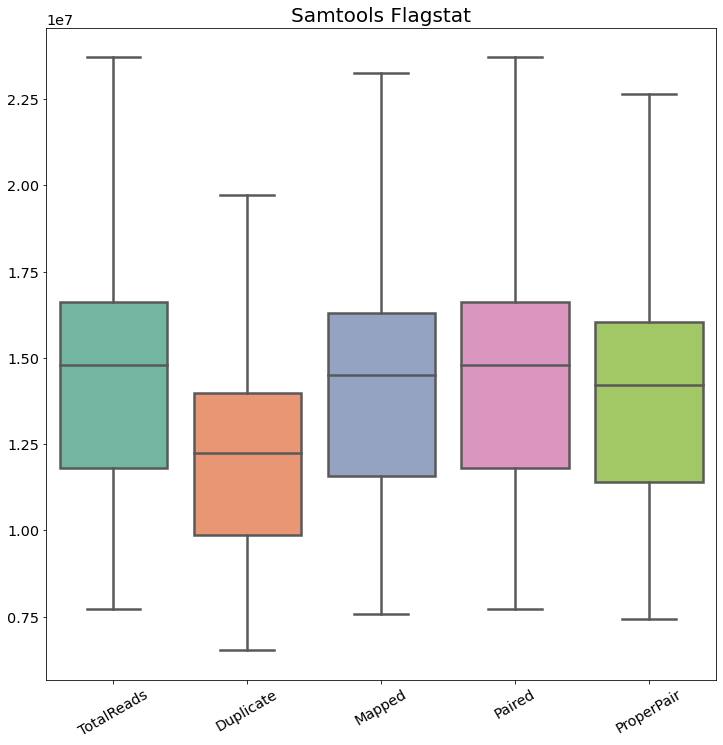

In [34]:
fig, ax = plt.subplots(figsize=(12,12))

plot_cats = ['TotalReads', 'Duplicate', 'Mapped', 'Paired', 'ProperPair']
sns.boxplot(data=flag_df[plot_cats], ax=ax, palette='Set2', linewidth=2.5)
ax.set_title('Samtools Flagstat', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.savefig('flagstats.png', dpi=200, bbox_inches='tight')
plt.show()

In [35]:
flag_df.index = [x.split('_')[-1] for x in flag_df.index]

In [36]:
flag_df.to_csv('alignment_stats.csv')

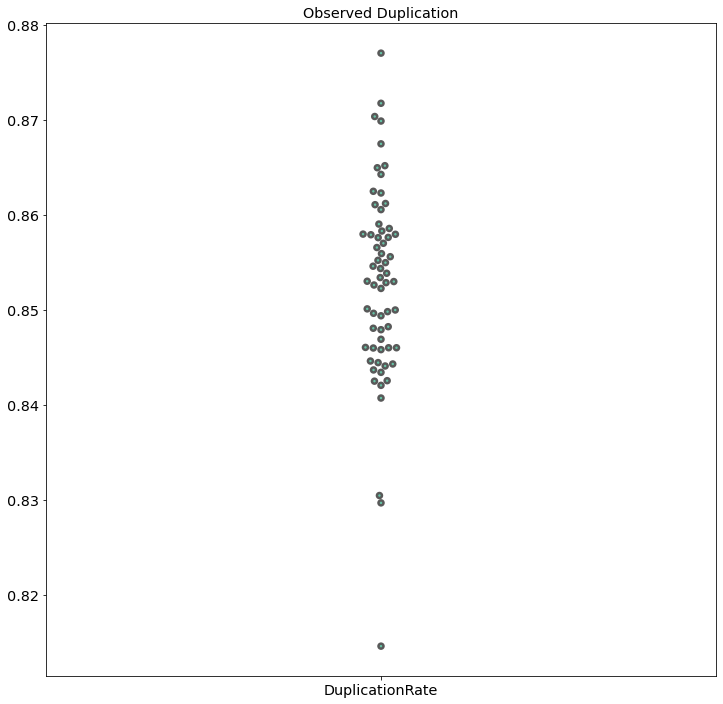

In [37]:
fig, ax = plt.subplots(figsize=(12,12))

plot_cats = ['DuplicationRate']
sns.swarmplot(data=flag_df[plot_cats], ax=ax, palette='Set2', linewidth=2.5)
ax.set_title('Observed Duplication')
#plt.savefig('duplication.png', dpi=200, bbox_inches='tight')
plt.show()

### Pull CGmap Files

In [46]:
cgmap_files = [f'{wd}CGmaps/CGmap_1x/{sample}_01.CGmap_hq.CGmap.gz' for sample in samples]

In [47]:
for file in cgmap_files:
    if not os.path.exists(file):
        print(file)

In [48]:
if not os.path.exists(f'{wd}covid_count.txt'):
    matrix = AggregateMatrix(file_list=cgmap_files, sample_list=samples,
                            min_site_coverage=10, site_proportion_threshold=0.9, cg_only=True, verbose=True, threads=8,
                            output_path=f'{wd}covid_count.txt', count_matrix=True)
    matrix.aggregate_matrix()



Setting Methylation Sites:  97%|█████████▋| 61/63 [00:17<00:00,  3.46it/s]


### Matrix QC

In [49]:
count_df = pd.read_csv(f'{wd}covid_count.txt', sep='\t', index_col=0)

In [50]:
count_df['AverageCoverage'] = count_df[[col for col in list(count_df) if 'total' in col]].mean(axis=1)

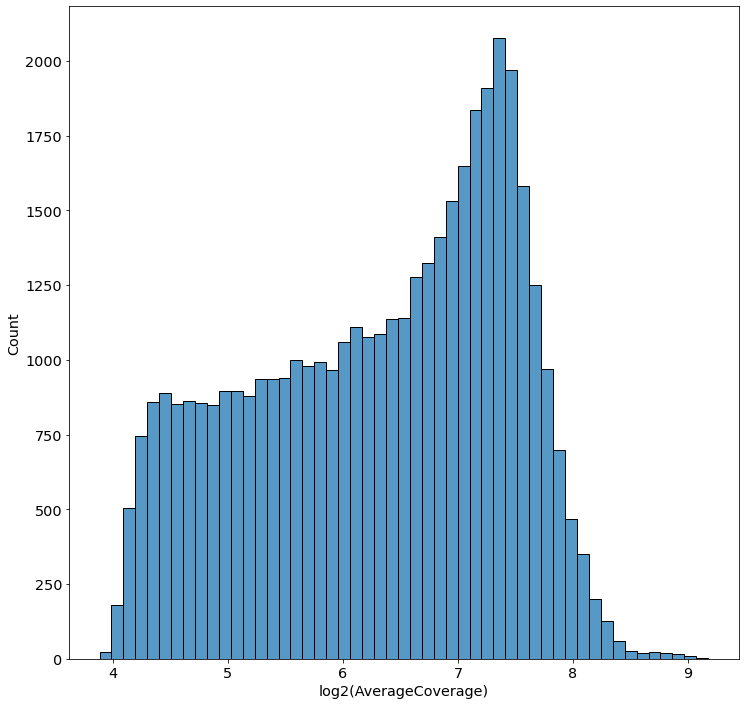

In [53]:
fig, ax = plt.subplots(figsize=(12,12))

sns.histplot(np.log2(count_df['AverageCoverage'].values), ax=ax)
ax.set_xlabel('log2(AverageCoverage)')
plt.show()

In [54]:
count_df = count_df.loc[count_df['AverageCoverage'] >= 30]

In [55]:
# construct value df from count df
# if total great than 10 keep site

def process_columns(meth_counts, total_counts, threshold=10):
    counts = np.array(meth_counts)
    counts[counts < threshold] = np.nan
    return meth_counts / total_counts   

In [56]:
value_matrix = []

for sample in samples:
    value_matrix.append(process_columns(count_df[f'{sample}_meth_cytosine'].values, 
                                        count_df[f'{sample}_total_cytosine'].values,
                                        15))
    
value_matrix = np.array(value_matrix).T

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [57]:
value_df = pd.DataFrame(value_matrix, columns=samples, index=count_df.index)

In [58]:
meth_matrix = value_df.dropna(axis=0)

In [59]:
meth_matrix.to_csv(f'{wd}covid_values.txt', sep='\t')

### Matrix QC
- assembled matrix is a complete matrix of sites with an average coverage of 30x
- minnimum coverage of 15x for all samples

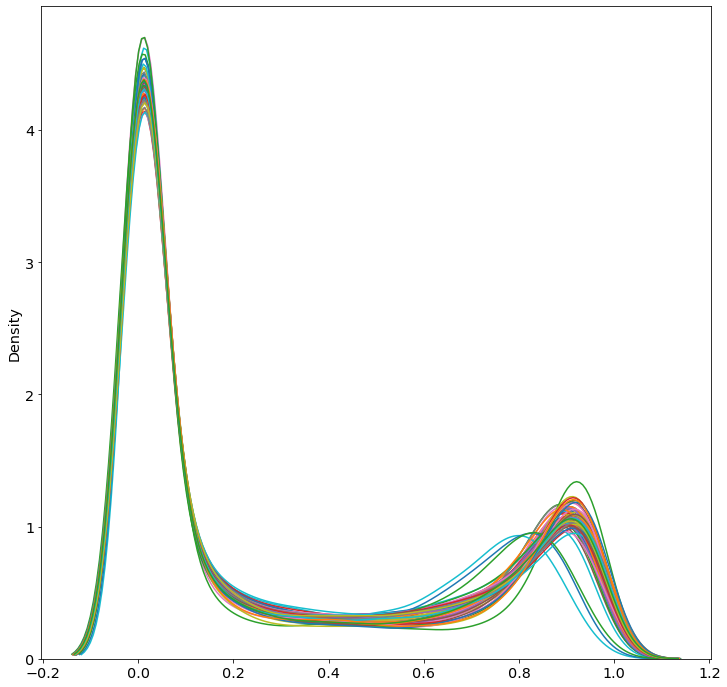

In [60]:
fig, ax = plt.subplots(figsize=(12,12))

for sample in tqdm(list(meth_matrix)):
    sns.kdeplot(meth_matrix[sample].values, ax=ax, label=sample)
    
plt.show()

In [63]:
pca = PCA()
pcs = pca.fit_transform(meth_matrix.values.T)  
pca_score = pca.explained_variance_ratio_

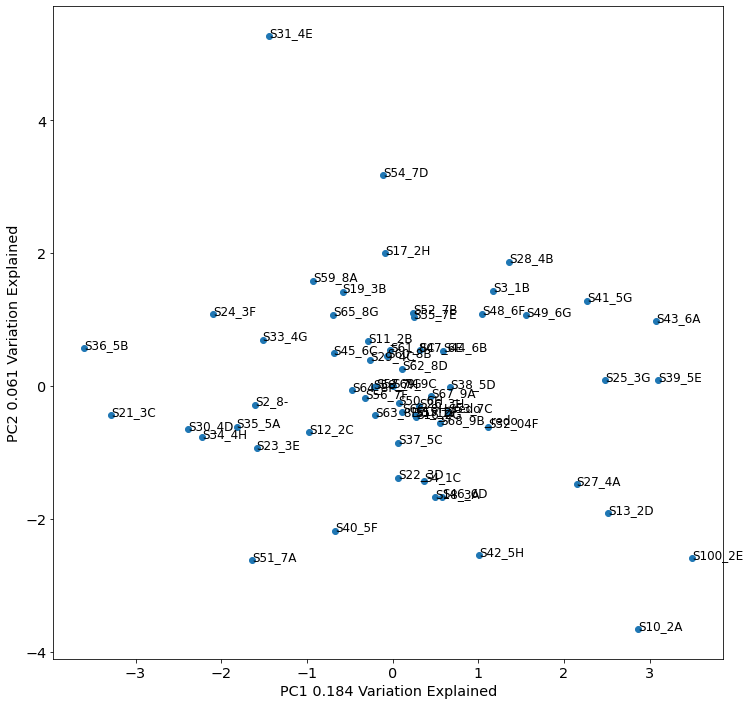

In [64]:
fig, ax = plt.subplots(figsize=(12,12))

plt.scatter(x=pcs[0], y=pcs[1])
for x, y, label in zip(pcs[0], pcs[1], list(meth_matrix)):
    ax.text(x,y, label, fontsize=12)
ax.set_xlabel(f'PC1 {pca_score[0]:.3f} Variation Explained')
ax.set_ylabel(f'PC2 {pca_score[1]:.3f} Variation Explained')
plt.savefig('pca_plot.png', dpi=100)
plt.show()